![title](img/picture.jpg)

# AvanGrid Zero Shot Energy Demand Forecasting with Granite Timeseries Foundation Model

In [ ]:
Tested with Python 3.9.6
Uses open source IBM Time Series Foundation Model (TSFM) library

### Import Packages

For this PoC, we use Pandas for Loading Data, Matplotlib for Visualization and IBM Granite TSFM TinyTimeMixer model, forecasting pipeline, and plotting function.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.visualization import plot_predictions

INFO:p-6587:t-8423051072:config.py:<module>:PyTorch version 2.5.1 available.
INFO:p-6587:t-8423051072:config.py:<module>:TensorFlow version 2.18.0 available.


### Get the data

For the PoC we have used a publicaly available dataset of hourly electrical demand, generation by type, prices, and weather in Spain from Kaggle

In [2]:
DATA_FILE_PATH = 'data/energy_dataset.csv.zip'

### Specify time and target variables

Here we specify which column in the dataset contains time value and what is the target variable. The context length (in time steps) is set to match the pretrained model.

In [5]:
timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512

### Data Preparation

WHere we load the data into a pandas dataframe, and impute any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a datetime.

In [6]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
  DATA_FILE_PATH,
  parse_dates=[timestamp_column], # Parse the timestamp values as dates.
)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Time Series Visualiztaion

Here we Visualize the Data

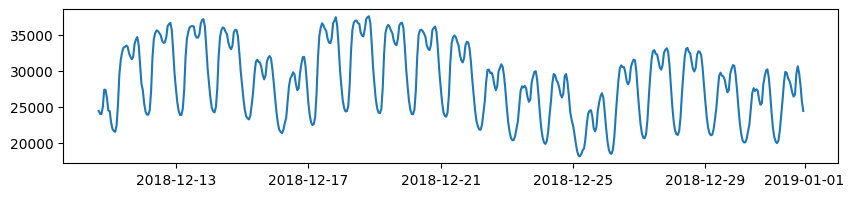

In [11]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

### Zero Shot Time Series Forecasting
The IBM Granite TSFM is hosted on HuggiggFace, and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. 

In [7]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-r2", # Name of the model on HuggingFace.
  num_input_channels=len(target_columns) # tsp.num_input_channels,
)

### Time Series forecasting pipeline

Here we setup the pipeline with the model and pass the data to the pipeline to make the forecast. This pipeline uses CPU for processing

In [8]:
# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="h",
    device="cpu", # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

,time,total load actual_prediction
91,2019-01-04 19:00:00+01:00,31369.990234
92,2019-01-04 20:00:00+01:00,31666.271484
93,2019-01-04 21:00:00+01:00,31094.181641
94,2019-01-04 22:00:00+01:00,29409.896484
95,2019-01-04 23:00:00+01:00,27393.580078


### Visualize predictions along with historical data

Here we plot the forecast with historical data

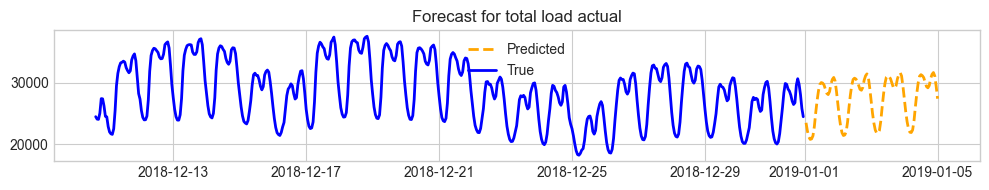

In [12]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=input_df,
    exploded_predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1],
    num_plots=1,
)